# Bank Loan Analysis — Exploratory Notebook

This notebook provides a reproducible analysis pipeline for the `financial_loan.csv` dataset. It mirrors the SQL queries used in the project and adds visualizations and notes for interview-ready presentation.

**Files used:** `/mnt/data/financial_loan.csv`, `/mnt/data/DATA_ANALYSIS_DASHBOARD.xlsx`, `/mnt/data/Loan Sql Report.pdf`

Run the cells sequentially. If `issue_date` parsing fails, inspect the date format in the CSV.


## 1. Imports and configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

## 2. Load dataset
The notebook expects `financial_loan.csv` to be in `/mnt/data/`.

In [4]:
# Load CSV
csv_path = 'financial_loan.csv'

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Dataset not found at {csv_path}. Please upload the CSV to /mnt/data/financial_loan.csv")

# Try reading with automatic parsing for dates
df = pd.read_csv(csv_path, low_memory=False)

# preview
print('Rows, Columns:', df.shape)
df.head()

Rows, Columns: (38576, 24)


,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,loan_status,next_payment_date,member_id,purpose,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,11-02-2021,13-09-2021,13-04-2021,Charged Off,13-05-2021,1314167,car,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,01-01-2021,14-12-2021,15-01-2021,Fully Paid,15-02-2021,1288686,car,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,05-01-2021,12-12-2021,09-01-2021,Charged Off,09-02-2021,1304116,car,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,12-12-2021,12-03-2021,Fully Paid,12-04-2021,1272024,car,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,01-01-2021,14-12-2021,15-01-2021,Fully Paid,15-02-2021,1302971,car,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


## 3. Quick data checks

In [5]:
# Data types & missing values

df.info()

# Basic null counts
nulls = df.isnull().sum().sort_values(ascending=False)
nulls[nulls>0].head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

emp_title    1438
dtype: int64

## 4. Clean & prepare columns
- Ensure numeric columns are numeric
- Parse `issue_d` / `issue_date` as datetime if present
- Standardize column names to lowercase for reproducibility

In [6]:
# Standardize column names
original_columns = list(df.columns)
df.columns = [c.strip() for c in df.columns]

# Try common variants
for cand in ['issue_date','issue_d','issueDate','issueDate']:
    if cand in df.columns:
        df['issue_date'] = pd.to_datetime(df[cand], errors='coerce')
        break

# if issue_date not created, attempt to parse any column that looks like a date
if 'issue_date' not in df.columns:
    for c in df.columns:
        if 'date' in c.lower() or 'issue' in c.lower():
            df['issue_date'] = pd.to_datetime(df[c], errors='coerce')
            break

# numeric conversions
for col in ['loan_amount','total_payment','int_rate','dti']:
    if col in df.columns:
        # remove percent sign if present in int_rate and convert
        df[col] = df[col].astype(str).str.replace('%','', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# show changes
print('Columns before -> after (sample):')
print(original_columns[:10])
print('\nCurrent columns (first 20):', list(df.columns)[:20])

df[['issue_date']].head()

Columns before -> after (sample):
['id', 'address_state', 'application_type', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'issue_date', 'last_credit_pull_date', 'last_payment_date']

Current columns (first 20): ['id', 'address_state', 'application_type', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'issue_date', 'last_credit_pull_date', 'last_payment_date', 'loan_status', 'next_payment_date', 'member_id', 'purpose', 'sub_grade', 'term', 'verification_status', 'annual_income', 'dti', 'installment']


,issue_date
0,2021-11-02
1,2021-01-01
2,2021-05-01
3,NaT
4,2021-01-01


## 5. Key Performance Indicators (KPIs)
The cells below compute the main KPIs using pandas — these mirror the SQL queries in your report.

In [7]:
# Total loan applications
kpi_total_applications = len(df)
print('Total Applications:', kpi_total_applications)

# Total funded amount
kpi_total_funded = df['loan_amount'].sum() if 'loan_amount' in df.columns else np.nan
print('Total Funded Amount:', kpi_total_funded)

# Total amount received
kpi_total_received = df['total_payment'].sum() if 'total_payment' in df.columns else np.nan
print('Total Amount Received:', kpi_total_received)

# Average interest rate (as percentage)
if 'int_rate' in df.columns:
    kpi_avg_interest = df['int_rate'].mean()
else:
    kpi_avg_interest = np.nan
print('Avg Interest Rate (%):', kpi_avg_interest)

# Average DTI
kpi_avg_dti = df['dti'].mean() if 'dti' in df.columns else np.nan
print('Avg DTI (%):', kpi_avg_dti)

# Display as a small DataFrame
kpis = pd.DataFrame({
    'metric':['Total Applications','Total Funded Amount','Total Amount Received','Avg Interest Rate (%)','Avg DTI (%)'],
    'value':[kpi_total_applications,kpi_total_funded,kpi_total_received,round(kpi_avg_interest,2) if pd.notnull(kpi_avg_interest) else np.nan,round(kpi_avg_dti,2) if pd.notnull(kpi_avg_dti) else np.nan]
})
kpis

Total Applications: 38576
Total Funded Amount: 435757075
Total Amount Received: 473070933
Avg Interest Rate (%): 0.12048831397760265
Avg DTI (%): 0.13327433119037743


,metric,value
0,Total Applications,3.857600e+04
1,Total Funded Amount,4.357571e+08
2,Total Amount Received,4.730709e+08
3,Avg Interest Rate (%),1.200000e-01
4,Avg DTI (%),1.300000e-01


## 6. Good vs Bad loans
Classify good loans as `Fully Paid` or `Current`, bad loans as `Charged Off`. Compute counts, sums and percentages.

In [8]:
status_col = None
for c in df.columns:
    if 'loan_status' == c or c.lower() == 'loan_status':
        status_col = 'loan_status'
        break

if status_col is None:
    # try to find a close match
    for c in df.columns:
        if 'status' in c.lower():
            status_col = c
            break

if status_col is None:
    raise KeyError('No loan status column found. Please ensure a status column exists.')

# Normalize status values
df['loan_status_clean'] = df[status_col].astype(str).str.strip()

good_mask = df['loan_status_clean'].isin(['Fully Paid','Current'])
bad_mask = df['loan_status_clean'].str.contains('Charged Off', na=False)

good_count = good_mask.sum()
bad_count = bad_mask.sum()

print('Good count:', good_count)
print('Bad count:', bad_count)
print('Good %:', round(100*good_count/len(df),2))
print('Bad %:', round(100*bad_count/len(df),2))

# sums
good_funded = df.loc[good_mask,'loan_amount'].sum()
bad_funded = df.loc[bad_mask,'loan_amount'].sum()

print('Good funded sum:', good_funded)
print('Bad funded sum:', bad_funded)

pd.DataFrame({
    'segment':['Good','Bad','Total'],
    'count':[good_count,bad_count,len(df)],
    'funded_sum':[good_funded,bad_funded,kpi_total_funded]
})

Good count: 33243
Bad count: 5333
Good %: 86.18
Bad %: 13.82
Good funded sum: 370224850
Bad funded sum: 65532225


,segment,count,funded_sum
0,Good,33243,370224850
1,Bad,5333,65532225
2,Total,38576,435757075


## 7. Loan status breakdown (grouped KPIs)

In [9]:
group_cols = ['loan_status_clean']
agg = df.groupby(group_cols).agg(
    Total_Applications = ('loan_status_clean','count'),
    Total_Funded_Amount = ('loan_amount','sum'),
    Total_Amount_Received = ('total_payment','sum'),
    Average_Interest_Rate = ('int_rate','mean'),
    Average_DTI = ('dti','mean')
).reset_index()

# round numeric columns for display
for c in ['Average_Interest_Rate','Average_DTI']:
    if c in agg.columns:
        agg[c] = agg[c].round(2)

agg.sort_values('Total_Applications', ascending=False).head(20)

,loan_status_clean,Total_Applications,Total_Funded_Amount,Total_Amount_Received,Average_Interest_Rate,Average_DTI
2,Fully Paid,32145,351358350,411586256,0.12,0.13
0,Charged Off,5333,65532225,37284763,0.14,0.14
1,Current,1098,18866500,24199914,0.15,0.15


## 8. Monthly (MTD/PMTD) calculations — example: Dec 2021 vs Nov 2021

In [10]:
# Ensure issue_date exists
if 'issue_date' not in df.columns:
    print('No issue_date column parsed; monthly KPIs cannot be computed. Inspect date columns and formats.')
else:
    df['year'] = df['issue_date'].dt.year
    df['month'] = df['issue_date'].dt.month
    
    mtd_mask = (df['year']==2021) & (df['month']==12)
    pmtd_mask = (df['year']==2021) & (df['month']==11)
    
    mtd_apps = mtd_mask.sum()
    pmtd_apps = pmtd_mask.sum()
    
    mtd_funded = df.loc[mtd_mask,'loan_amount'].sum()
    pmtd_funded = df.loc[pmtd_mask,'loan_amount'].sum()
    
    mtd_received = df.loc[mtd_mask,'total_payment'].sum()
    pmtd_received = df.loc[pmtd_mask,'total_payment'].sum()
    
    print('MTD (Dec 2021) Applications:', mtd_apps)
    print('PMTD (Nov 2021) Applications:', pmtd_apps)
    print('MTD Funded:', mtd_funded)
    print('PMTD Funded:', pmtd_funded)
    
    pd.DataFrame({
        'metric':['MTD_apps','PMTD_apps','MTD_funded','PMTD_funded','MTD_received','PMTD_received'],
        'value':[mtd_apps,pmtd_apps,mtd_funded,pmtd_funded,mtd_received,pmtd_received]
    })

MTD (Dec 2021) Applications: 1
PMTD (Nov 2021) Applications: 20850
MTD Funded: 5000
PMTD Funded: 253208725


## 9. Visualizations
Small set of plots to include in the repo (saved as PNGs). Each plot uses matplotlib (one plot per cell).

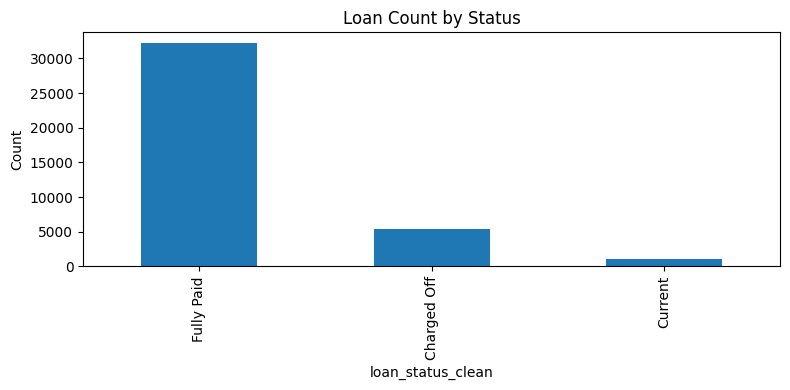

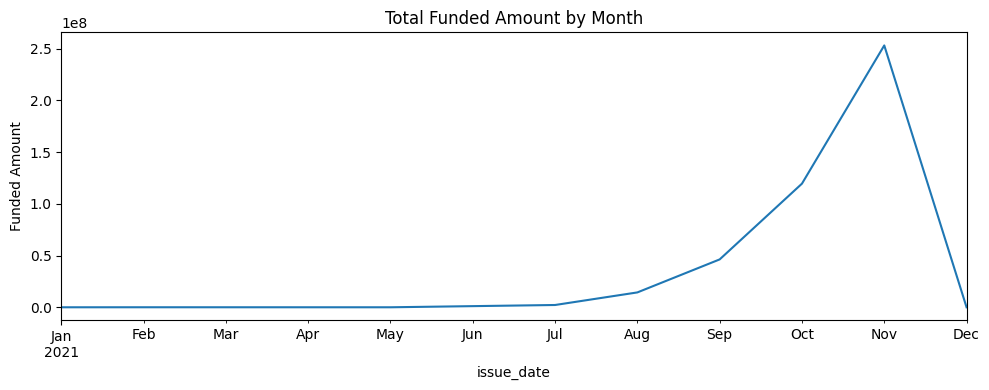

Plots saved to /mnt/data/plots


In [11]:
plots_dir = '/mnt/data/plots'
os.makedirs(plots_dir, exist_ok=True)

# 1) Loan count by status (bar)
fig, ax = plt.subplots(figsize=(8,4))
status_counts = df['loan_status_clean'].value_counts().sort_values(ascending=False)
status_counts.plot(kind='bar', ax=ax)
ax.set_title('Loan Count by Status')
ax.set_ylabel('Count')
plt.tight_layout()
plot1 = os.path.join(plots_dir,'loan_count_by_status.png')
fig.savefig(plot1)
plt.show()

# 2) Total funded by month (if date exists)
if 'issue_date' in df.columns and df['issue_date'].notna().sum()>0:
    monthly = df.groupby(df['issue_date'].dt.to_period('M'))['loan_amount'].sum()
    fig2, ax2 = plt.subplots(figsize=(10,4))
    monthly_plot = monthly.plot(ax=ax2)
    ax2.set_title('Total Funded Amount by Month')
    ax2.set_ylabel('Funded Amount')
    plt.tight_layout()
    plot2 = os.path.join(plots_dir,'funded_by_month.png')
    fig2.savefig(plot2)
    plt.show()
else:
    print('Skipping monthly plot — issue_date not parsed.')

print('Plots saved to', plots_dir)

## 10. Next steps / reproducibility notes
- If you want SQL-runner reproducibility, consider loading the CSV into SQLite and running the `.sql` file against it.
- Add a `requirements.txt` (pandas, matplotlib, numpy) and this notebook under `notebooks/analysis.ipynb` in your repo.
- The plots generated are saved in `/mnt/data/plots` — include them in `images/` in the repo for README display.

----

*Notebook generated automatically. Save and run this notebook (Kernel: Python 3) to reproduce the analysis locally or in Colab.*